# Predicting News Reliablity Using News Content

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm, naive_bayes, tree, ensemble, neighbors, linear_model
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
# from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, f1_score, precision_score, recall_score
import itertools
from IPython.display import display
from sklearn.dummy import DummyClassifier

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) 

CSV_FILE_DIR_HEAD = "/Volumes/MySSD/PycharmProjects/MIS-COV19/"
CONTENT_FEATURE_PATH = CSV_FILE_DIR_HEAD+"feature/content-features.csv"
LABEL_PATH = CSV_FILE_DIR_HEAD+"feature/labels.csv"
CLASSES = ['is_reliable', 'is_unreliable']
RSEED = 46

Data Preprocessing

In [72]:
def date_prep(fea_path, lab_path):
    # Load data
    fea_data = pd.read_csv(fea_path)  
    lab_data = pd.read_csv(lab_path) 
    
    features = pd.DataFrame(fea_data)  
    labels = pd.DataFrame(lab_data)
    
    # Feature standardization
    fea_scale = preprocessing.scale(features)
    
    # Read feature names
    fea_names = features.columns
    
    # Divide the overall dataset as training data and testing data (0.8:0.2)
    x_train, x_test, y_train, y_test = train_test_split(fea_scale, labels, test_size=0.2, random_state=RSEED)

    return fea_names, x_train, x_test, y_train, y_test

Logistic Regression
    

In [73]:
fea_names, x_train, x_test, y_train, y_test = date_prep(CONTENT_FEATURE_PATH, LABEL_PATH)

model = linear_model.LogisticRegression(random_state=RSEED)
model.fit(x_train, y_train)

# perm = PermutationImportance(model, random_state=RSEED).fit(x_train, y_train)
# display(eli5.show_weights(perm, feature_names = fea_names.tolist()))

y_pred = model.predict(x_test)

# cm_lg = confusion_matrix(y_test, y_pred)

print('=== Logistic Regression ===')
print(classification_report(y_test, y_pred, target_names=CLASSES))
# print(cm_lg)
# plot_cm(cm_lg, classes,
#         path = 'confusion matrix/cm_lg.eps',
#         normalize=True,
#         cmap=plt.cm.Blues)



=== Logistic Regression ===
               precision    recall  f1-score   support

  is_reliable       0.80      0.90      0.85       274
is_unreliable       0.72      0.52      0.61       132

     accuracy                           0.78       406
    macro avg       0.76      0.71      0.73       406
 weighted avg       0.77      0.78      0.77       406



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Naive Bayes
    

In [74]:
fea_names, x_train, x_test, y_train, y_test = date_prep(CONTENT_FEATURE_PATH, LABEL_PATH)

'''
Determining parameters:
Cross validation based on grid search

res = []
for alpha in np.arange(0.1,1,0.1):
    for binarize in np.arange(0,1,0.1):
        model = naive_bayes.BernoulliNB(alpha=alpha, binarize=binarize)
        cv_results = cross_val_score(model, x_train, y_train, scoring='f1', cv=10)
        res.append([alpha, binarize, cv_results.mean()])
bst_params = max(res, key=lambda re: re[-1])
bst_alpha = bst_params[0]
bst_binarize = bst_params[1]
print('bst_params: [ %.1f, %.1f ]' %(bst_alpha,bst_binarize))

# bst_alpha = 0.1
# bst_binarize = 0
model = naive_bayes.BernoulliNB(alpha=bst_alpha, binarize=bst_binarize)    
'''

model = naive_bayes.BernoulliNB() 
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print('=== Naive Bayes ===')
print(classification_report(y_test, y_pred, target_names=CLASSES))

=== Naive Bayes ===
               precision    recall  f1-score   support

  is_reliable       0.78      0.88      0.83       274
is_unreliable       0.66      0.50      0.57       132

     accuracy                           0.75       406
    macro avg       0.72      0.69      0.70       406
 weighted avg       0.74      0.75      0.74       406



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


K-Nearest Neighbors
    

In [75]:
fea_names, x_train, x_test, y_train, y_test = date_prep(CONTENT_FEATURE_PATH, LABEL_PATH)

'''
Determining parameters:
Cross validation based on grid search

res = []
for n_neighbors in np.arange(1,10,1):
    model = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    cv_results = cross_val_score(model, x_train, y_train, scoring='f1', cv=10)
    res.append([n_neighbors, cv_results.mean()])
bst_params = max(res, key=lambda re: re[-1])
bst_n_neighbors = bst_params[0]
print('bst_params: [ %.1f ]' %(bst_n_neighbors))

# bst_n_neighbors = 3
model = neighbors.KNeighborsClassifier(n_neighbors=bst_n_neighbors)
'''

model = neighbors.KNeighborsClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print('=== KNN ===')
print(classification_report(y_test, y_pred, target_names=CLASSES))


=== KNN ===
               precision    recall  f1-score   support

  is_reliable       0.85      0.89      0.87       274
is_unreliable       0.76      0.68      0.72       132

     accuracy                           0.83       406
    macro avg       0.80      0.79      0.80       406
 weighted avg       0.82      0.83      0.82       406



<ipython-input-75-6351427c1e8c>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  model.fit(x_train, y_train)


Random Forest

<ipython-input-76-993a56b679c5>:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


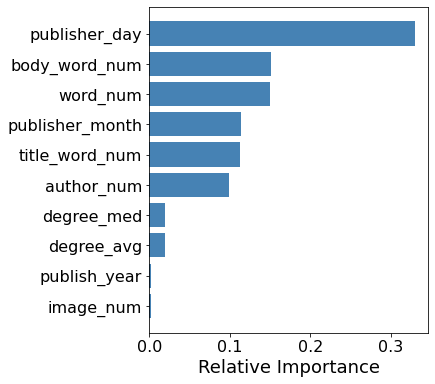

=== Random Forest ===
               precision    recall  f1-score   support

  is_reliable       0.88      0.90      0.89       274
is_unreliable       0.78      0.75      0.76       132

     accuracy                           0.85       406
    macro avg       0.83      0.82      0.83       406
 weighted avg       0.85      0.85      0.85       406



In [76]:
fea_names, x_train, x_test, y_train, y_test = date_prep(CONTENT_FEATURE_PATH, LABEL_PATH)

'''
Determining parameters:
Cross validation based on grid search

res = []
for n_estimators in np.arange(100,500,100):
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,random_state=RSEED)
    cv_results = cross_val_score(model, x_train, y_train, scoring='f1', cv=10)
    res.append([n_estimators, cv_results.mean()])
bst_params = max(res, key=lambda re: re[-1])
bst_n_estimators = bst_params[0]
print('bst_params: [ %.1f ]' %(bst_n_estimators))

# bst_n_estimators = 300
model = ensemble.RandomForestClassifier(n_estimators=bst_n_estimators)
'''
model = ensemble.RandomForestClassifier()
model.fit(x_train, y_train)

importances = model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(5,6))
plt.barh(range(len(indices)), importances[indices], color='steelblue', align='center')
plt.yticks(range(len(indices)), [str(fea_names[i]) for i in indices])
plt.xlabel('Relative Importance')
# plt.savefig('figure/fea_imp_rf.eps',bbox_inches='tight')
plt.show()

y_pred = model.predict(x_test)

print('=== Random Forest ===')
print(classification_report(y_test, y_pred, target_names=CLASSES))


Decision Tree

In [77]:
fea_names, x_train, x_test, y_train, y_test = date_prep(CONTENT_FEATURE_PATH, LABEL_PATH)

model = tree.DecisionTreeClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print('=== Decision Tree ===')
print(classification_report(y_test, y_pred, target_names=CLASSES))


=== Decision Tree ===
               precision    recall  f1-score   support

  is_reliable       0.89      0.82      0.85       274
is_unreliable       0.68      0.80      0.73       132

     accuracy                           0.81       406
    macro avg       0.78      0.81      0.79       406
 weighted avg       0.82      0.81      0.81       406



SVM

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


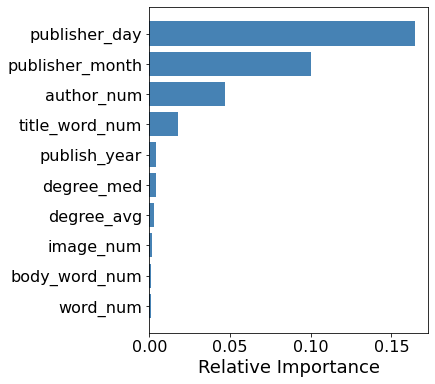

=== SVM ===
               precision    recall  f1-score   support

  is_reliable       0.85      0.92      0.89       274
is_unreliable       0.81      0.67      0.74       132

     accuracy                           0.84       406
    macro avg       0.83      0.80      0.81       406
 weighted avg       0.84      0.84      0.84       406



In [78]:
fea_names, x_train, x_test, y_train, y_test = date_prep(CONTENT_FEATURE_PATH, LABEL_PATH)

# kernel = 'rbf'
# max_iter = 2000
# model = svm.SVC(C=0.6, kernel=kernel, max_iter=max_iter, tol=0.01, random_state=RSEED)
model = svm.SVC(random_state=RSEED)
model.fit(x_train, y_train)

importances = permutation_importance(model, x_train, y_train)['importances_mean']
indices = np.argsort(importances)
plt.figure(figsize=(5,6))
plt.barh(range(len(indices)), importances[indices], color='steelblue', align='center')
plt.yticks(range(len(indices)), [str(fea_names[i]) for i in indices])
plt.xlabel('Relative Importance')
# plt.savefig('feature importance/fea_imp_svm.eps',bbox_inches='tight')
plt.show()

y_pred = model.predict(x_test)

print('=== SVM ===')
print(classification_report(y_test, y_pred, target_names=CLASSES))

XGBoost

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


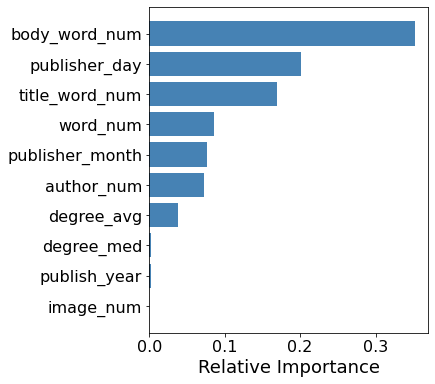

=== XGBoost ===
               precision    recall  f1-score   support

  is_reliable       0.89      0.90      0.90       274
is_unreliable       0.79      0.78      0.79       132

     accuracy                           0.86       406
    macro avg       0.84      0.84      0.84       406
 weighted avg       0.86      0.86      0.86       406



In [79]:
fea_names, x_train, x_test, y_train, y_test = date_prep(CONTENT_FEATURE_PATH, LABEL_PATH)

model = XGBClassifier(max_depth=5, subsample=0.6, reg_lambda=0.6, seed=RSEED)
model.fit(x_train, y_train)

importances = model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(5,6))
plt.barh(range(len(indices)), importances[indices], color='steelblue', align='center')
plt.yticks(range(len(indices)), [str(fea_names[i]) for i in indices])
plt.xlabel('Relative Importance')
# plt.savefig('figure/fea_imp_xgb.eps',bbox_inches='tight')
plt.show()

y_pred = model.predict(x_test)

print('=== XGBoost ===')
print(classification_report(y_test, y_pred, target_names=CLASSES))

Performance of Random Classifier

In [80]:
fea_names, x_train, x_test, y_train, y_test = date_prep(CONTENT_FEATURE_PATH, LABEL_PATH)

model = DummyClassifier(strategy="uniform")
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
cm_rand = confusion_matrix(y_test, y_pred)

print('=== Random ===')
print(classification_report(y_test, y_pred, target_names=CLASSES))



=== Random ===
               precision    recall  f1-score   support

  is_reliable       0.67      0.49      0.56       274
is_unreliable       0.32      0.49      0.38       132

     accuracy                           0.49       406
    macro avg       0.49      0.49      0.47       406
 weighted avg       0.55      0.49      0.50       406

